# AML Challenge 2 Baseline Solution

This notebook is based on the Github [respository](https://github.com/daisukelab/dcase2020_task2_variants). 

We replicate the (Variational Auto-Encoder) VAE method for this AML challenge 2 which is a small scale of the official DCASE challenge [task 2](https://dcase.community/challenge2020/task-unsupervised-detection-of-anomalous-sounds). 

# Required Python Packages

Let's install some python packages used in this notebook.

In [2]:
!pip install torchsummary
!pip install dl-cliche

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00


In [3]:
pip install pytorch-lightning==1.9.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 15.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.1.2
    Uninstalling pytorch-lightning-2.1.2:
      Successfully uninstalled pytorch-lightning-2.1.2
Note: you may need to restart the kernel to use updated packages.


To import our own functions, you could upload the .py files in the input folder and do as we do for the "common.py" and "pytorch_common.py" files.

In [4]:
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/dcase2020-task2-baseline/pytorch_common.py", dst = "../working/pytorch_common.py")
copyfile(src = "../input/dcase2020-task2-baseline/common.py", dst = "../working/common.py")

# import all our functions
import common as com
import pytorch_common
from pytorch_common import *

# public modules
import torch
import torch.nn.functional as F
import torchsummary
import pytorch_lightning as pl
import random
import common as com
import librosa
import os
import glob
import csv
import re
import itertools
import sys
import path
import numpy
import seaborn as sns
from torch import nn
from tqdm import tqdm
from sklearn import metrics
from dlcliche.utils import *
from dlcliche.notebook import *
from dlcliche.utils import (
    sys, random, Path, np, plt, EasyDict,
    ensure_folder, deterministic_everything,
)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
torch.cuda.device_count()

1

# Data Exploration

How many samples included?

How are the raw wave files?

How are the log mel spectrogram of the wave files?

Machine types: ['slider']


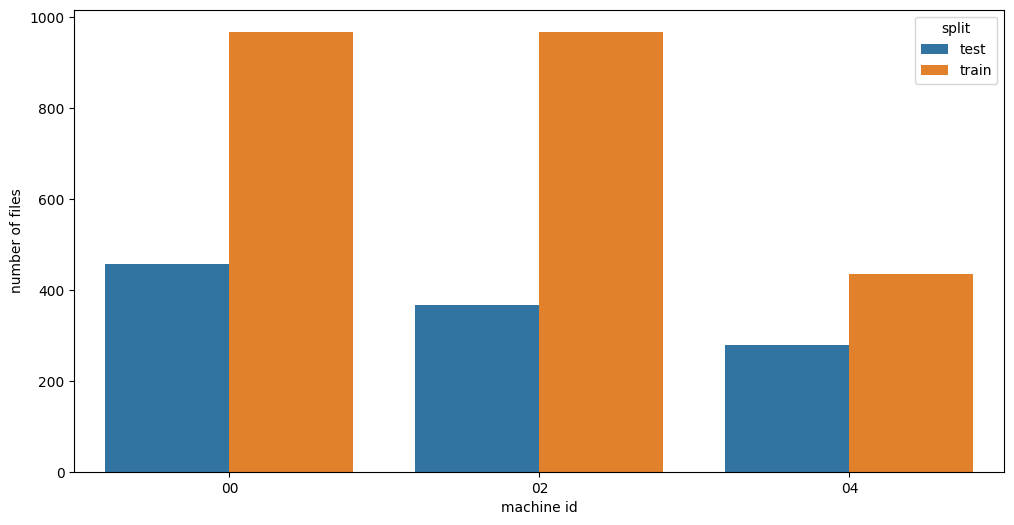

id      00         02         04      
split test train test train test train
file   456   968  367   968  278   434
type   456   968  367   968  278   434

In [6]:
# development dataset
DATA_ROOT=Path("../input/eurecom-aml-2023-challenge-2/dev_data/dev_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df = pd.DataFrame()
df['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df['type'] = df.file.map(lambda f: f.parent.parent.name)
df['split'] = df.file.map(lambda f: f.parent.name)
df['id'] = df.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

In [7]:
df.shape

(3471, 4)

In [8]:
#df.head()
df_train = df[df["split"] == 'train']
df_test = df[df["split"] == 'test']

print(f'Train set: {df_train.shape}')
print(f'Test set: {df_test.shape}')

Train set: (2370, 4)
Test set: (1101, 4)


Machine types: ['slider']


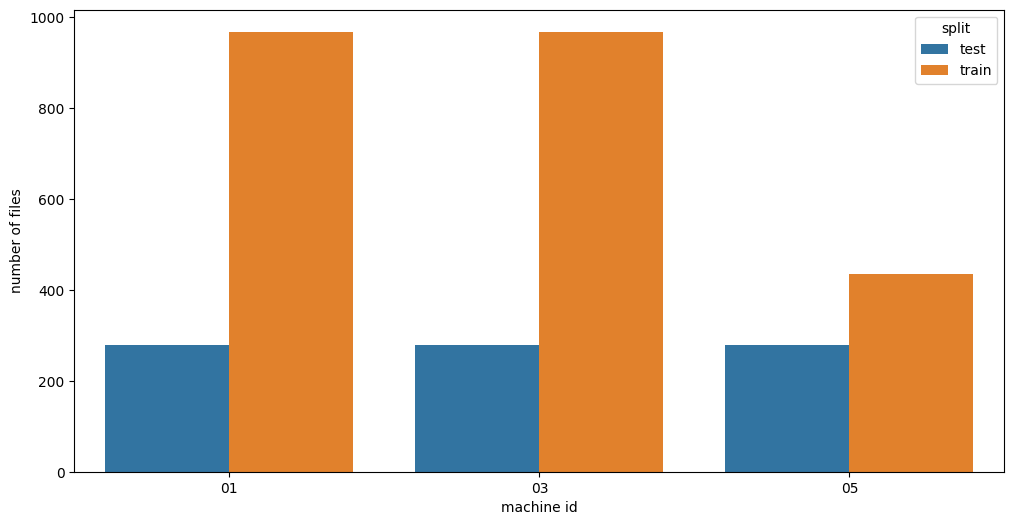

id      01         03         05      
split test train test train test train
file   278   968  278   968  278   434
type   278   968  278   968  278   434

In [9]:
# evaluation dataset
DATA_ROOT=Path("../input/eurecom-aml-2023-challenge-2/eval_data/eval_data")
types = [t.name for t in sorted(DATA_ROOT.glob('*')) if t.is_dir()]
print('Machine types:', types)

df_eval = pd.DataFrame()
df_eval['file'] = sorted(DATA_ROOT.glob('*/*/*.wav'))
df_eval['type'] = df_eval.file.map(lambda f: f.parent.parent.name)
df_eval['split'] = df_eval.file.map(lambda f: f.parent.name)
df_eval['id'] = df_eval.file.map(lambda s: str(s).split('/')[-1].split('_')[-2])

agg = df_eval.groupby(['id', 'split']).agg('count')
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x="id", y="file", hue="split", data=agg.reset_index())
plt.xlabel("machine id")
plt.ylabel("number of files")
plt.show()
agg.transpose()

In [10]:
df_eval.shape

(3204, 4)

In [11]:
df_eval.head()

file    type split  id
0  ../input/eurecom-aml-2023-challenge-2/eval_dat...  slider  test  01
1  ../input/eurecom-aml-2023-challenge-2/eval_dat...  slider  test  01
2  ../input/eurecom-aml-2023-challenge-2/eval_dat...  slider  test  01
3  ../input/eurecom-aml-2023-challenge-2/eval_dat...  slider  test  01
4  ../input/eurecom-aml-2023-challenge-2/eval_dat...  slider  test  01

=== Machine type [slider], train set ===


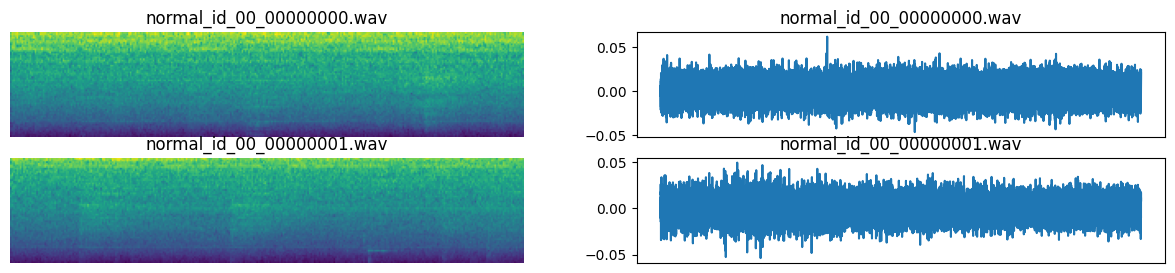

=== Machine type [slider], test set ===


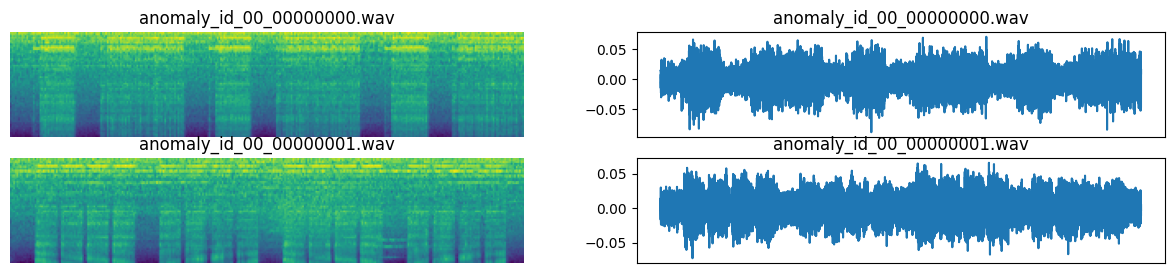

In [12]:
def get_log_mel_spectrogram(filename, n_mels=64,
                        n_fft=1024,
                        hop_length=512,
                        power=2.0):
    wav, sampling_rate = com.file_load(filename)
    mel_spectrogram = librosa.feature.melspectrogram(y=wav,
                                                     sr=sampling_rate,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)
    return log_mel_spectrogram, wav

for t in types:
    for split in ['train', 'test']:
        type_df = df[df['type'] == t][df.split == split].reset_index()
        R = 2
        fig, ax = plt.subplots(R, 2, figsize = (15, 1.5*R))
        print(f'=== Machine type [{t}], {split} set ===')
        for i in range(R * 2):
            file_index = i//2
            file_path = Path(type_df.file[file_index])
            mels, wav = get_log_mel_spectrogram(file_path)
            if i%2==0:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].imshow(mels)
                ax[i//2, i%2].axis('off')
            else:
                ax[i//2, i%2].set_title(file_path.name)
                ax[i//2, i%2].plot(wav)
                ax[i//2, i%2].get_xaxis().set_ticks([])
        plt.show()

The raw audio file is a time-series data which indicates the amplitude of the sound over time (right figures). 

However, deep learning models rarely take this raw audio directly as input, the common practice is to convert the audio into a spectrogram (left figures). The spectrogram is a concise ‘snapshot’ of an audio wave and since it is an image, it is well suited to being input to CNN-based architectures developed for handling images. If you want to understand the audio spectrogram, this Audio Deep Learning [series](https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504) is very useful. In this notebook, we use the spectrogram as input.

### Comparing normal and abnormal sound

In [13]:
df_train

file    type  split  id
1101  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  00
1102  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  00
1103  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  00
1104  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  00
1105  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  00
...                                                 ...     ...    ...  ..
3466  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  04
3467  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  04
3468  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  04
3469  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  04
3470  ../input/eurecom-aml-2023-challenge-2/dev_data...  slider  train  04

[2370 rows x 4 columns]

[]

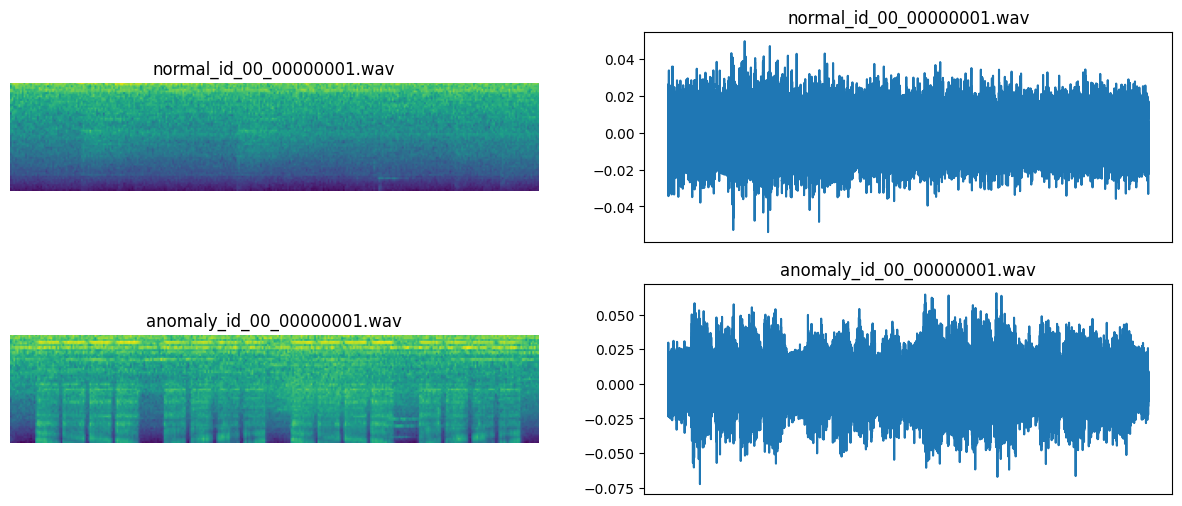

In [14]:
import soundfile as sf

#load a normal sound
normal_sound = df_train.file.iloc[1]
normal_signal, samplerate = sf.read(normal_sound)

#load an abnormal sound
abnormal_sound = df_test.file.iloc[1]
abnormal_signal, samplerate = sf.read(abnormal_sound)

fig, ax = plt.subplots(2, 2, figsize = (15, 3*2))
mels_n, wav_n = get_log_mel_spectrogram(normal_sound)
ax[0, 0].set_title(normal_sound.name)
ax[0, 0].imshow(mels_n)
ax[0, 0].axis('off')
ax[0, 1].set_title(normal_sound.name)
ax[0, 1].plot(wav_n)
ax[0, 1].get_xaxis().set_ticks([])

mels_a, wav_a = get_log_mel_spectrogram(abnormal_sound)
ax[1, 0].set_title(abnormal_sound.name)
ax[1, 0].imshow(mels_a)
ax[1, 0].axis('off')
ax[1, 1].set_title(abnormal_sound.name)
ax[1, 1].plot(wav_a)
ax[1, 1].get_xaxis().set_ticks([])

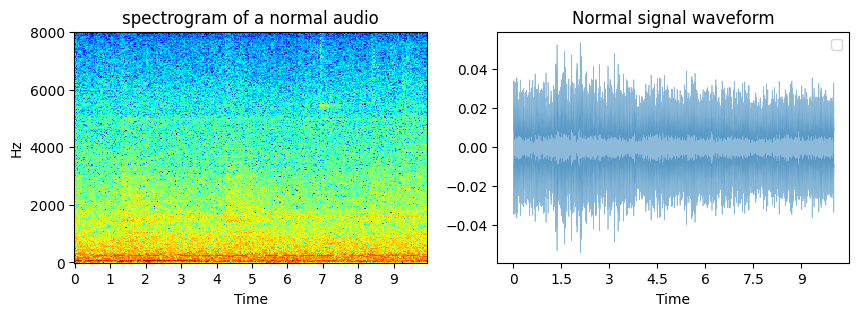

In [15]:
# plot the spectrogram of a normal sound
n_fft=1024
hop_length=512
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
S_normal = np.abs(librosa.stft(
    normal_signal, n_fft=n_fft, hop_length=hop_length, center=False))
librosa.display.specshow(
    librosa.amplitude_to_db(S_normal, ref=np.max), n_fft=n_fft, 
    hop_length=hop_length, sr=samplerate, x_axis='time', y_axis='linear',
    ax=ax[0], cmap='jet')
ax[0].set_title('spectrogram of a normal audio');

#display the waveform of a normal sound
import librosa.display
librosa.display.waveshow(normal_signal, sr=samplerate, alpha=0.5, linewidth=0.5)
ax[1].set_title('Normal signal waveform')
ax[1].legend();

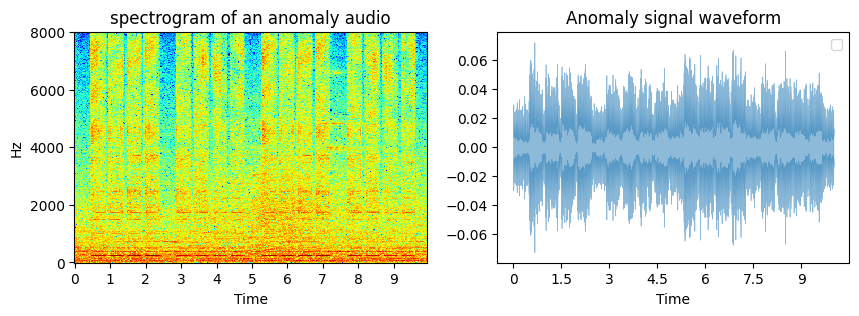

In [16]:
# plot the spectrogram of an anomaly sound
n_fft=1024
hop_length=512
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
S_anomaly = np.abs(librosa.stft(
    abnormal_signal, n_fft=n_fft, hop_length=hop_length, center=False))
librosa.display.specshow(
    librosa.amplitude_to_db(S_anomaly, ref=np.max), n_fft=n_fft, 
    hop_length=hop_length, sr=samplerate, x_axis='time', y_axis='linear',
    ax=ax[0], cmap='jet')
ax[0].set_title('spectrogram of an anomaly audio');

#display the waveform of an anomaly sound
import librosa.display
librosa.display.waveshow(abnormal_signal, sr=samplerate, alpha=0.5, linewidth=0.5)
ax[1].set_title('Anomaly signal waveform')
ax[1].legend();

# Network

## CNN Autoencoder

In [17]:
"""
Thanks to https://github.com/daisukelab/dcase2020_task2_variants/blob/master/3cnn_ae_pytorch/model.py
for the code for this CNN AE.
"""

class CNNAE(nn.Module):
    def  __init__(self, z_dim=40, skip_connections = False):
        super().__init__()
        
        self.skip_connections = skip_connections

        # define the network
        # encoder
        self.conv1 = nn.Sequential(nn.ZeroPad2d((1,2,1,2)),
                              nn.Conv2d(1, 32, kernel_size=5, stride=2),
                              nn.ReLU())
        self.conv2 = nn.Sequential(nn.ZeroPad2d((1,2,1,2)),
                              nn.Conv2d(32, 64, kernel_size=5, stride=2),
                              nn.ReLU(), nn.Dropout(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
                              nn.ReLU(), nn.Dropout(0.3))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0),
                              nn.ReLU(), nn.Dropout(0.3))
        self.fc1 = nn.Conv2d(256, z_dim, kernel_size=3)

        # decoder
        self.fc2 = nn.Sequential(nn.ConvTranspose2d(z_dim, 256, kernel_size=3),
                            nn.ReLU(), nn.Dropout(0.3))
        self.conv4d = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0),
                               nn.ReLU(), nn.Dropout(0.3))
        self.conv3d = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
                               nn.ReLU(), nn.Dropout(0.2))
        self.conv2d = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
                               nn.ReLU())
        self.conv1d = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2)

    def forward(self, x):
        if self.skip_connections:
            # x.shape (batch, 1, n_mels, n_mels )
            # encoder
            encoded = skip_1 = self.conv1(x)
            encoded = skip_2 = self.conv2(encoded)
            
            encoded = skip_3 = self.conv3(encoded)
            encoded = skip_4 = self.conv4(encoded)
            
            encoded = self.fc1(encoded)
            
            # decoder
            decoded = self.fc2(encoded)
            
            decoded = torch.cat([skip_4, decoded], dim=1)
            decoded = self.conv4d(decoded)
            
            decoded = torch.cat([skip_3, decoded], dim=1)
            decoded = self.conv3d(decoded)
           
            decoded = torch.cat([skip_2[:, :, :-1, :-1], decoded], dim=1)
            decoded = self.conv2d(decoded)            
            
            decoded = torch.cat([skip_1[:, :, :-1,:-1], decoded[:, :, 1:-1,1:-1]], dim=1)
            decoded = self.conv1d(decoded)[:,:,0:-1,0:-1]
            
            decoded = nn.Sigmoid()(decoded)
        else:
            # x.shape (batch, 1, n_mels, n_mels )
            encoded = self.conv1(x)
            encoded = self.conv2(encoded)
            encoded = self.conv3(encoded)
            encoded = self.conv4(encoded)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = self.conv4d(decoded)
            decoded = self.conv3d(decoded)
            decoded = self.conv2d(decoded)[:,:,1:-1,1:-1]
            decoded = self.conv1d(decoded)[:,:,0:-1,0:-1]

            decoded = nn.Sigmoid()(decoded)

        return decoded

# Parameters

## Parameters for CNNAE

In [18]:
params = {
# inout directory
"dev_directory" : "../input/eurecom-aml-2023-challenge-2/dev_data/dev_data",
"eval_directory" : "../input/eurecom-aml-2023-challenge-2/eval_data/eval_data",
"model_directory": "./model",
"result_directory": "./result",
"result_file": "result.csv",
"max_fpr" : 0.1,
"mode" : True, # mode=True for development dataset, mode=False for evaluation dataset
"skip_connection": False,

# preprocessing for mel-spectrogram
"feature": {
"n_mels": 128, #64
"frames" : 5,
"n_fft": 1024,
"hop_length": 512,
"power": 2.0, #2.0
"random": True,
"augment_tfm": None,
"augx": False,
"augy": False,
"debug": False,
"normalize": True},

# training
"fit":{
"lr": 0.0007,
"b1": 0.9,
"b2": 0.99,
"weight_decay": 0.0,
"epochs" : 100,
"batch_size" : 64, #256
"shuffle" : True,
"validation_split" : 0.1,
"verbose" : 1,
"nu": None}
    
}
params = EasyDict(params)

# Parameters for the grid search
lrs = [0.0007, 0.001] # Learning rates
bss = [64, 128]

# create working directory
ensure_folder(params.model_directory)


types = ['slider']

#data = {t:[f for f in data_files if t in str(f)] for t in types}

# fix random seeds
deterministic_everything(2020, pytorch=True)

# test directories
dirs = com.select_dirs(param=params, mode=params.mode)

# PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#data, types
dirs
slider_dir = dirs[0]
slider_dir

2024-01-07 19:21:34,790 - INFO - load_directory <- development


'/kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider'

# Training

## CNNAE Training

In [19]:
def list_to_vector_array_CNN(file_list,
                             n_mels=64,
                            n_fft=1024,
                            hop_length=512,
                            power=2.0
                            ):
    
    for idx, file in enumerate(file_list):
        log_mel_spect, _ = get_log_mel_spectrogram(file,
                                                n_mels=n_mels,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                power=power)

        if idx == 0:  # first file
            dataset = np.zeros(
                (len(file_list), 
                log_mel_spect.shape[0],
                log_mel_spect.shape[1])
            )
            com.logger.info(f'Created the  dataset shape ({dataset.shape})')
            dataset[idx, ...] = log_mel_spect
        else:
            dataset[idx, ...], _ = get_log_mel_spectrogram(file,
                                            n_mels=n_mels,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)
    return dataset

In [20]:
class DatasetCNN(torch.utils.data.Dataset):
    """
    Thanks to https://github.com/daisukelab/dcase2020_task2_variants for most of this code.
    """
    def __init__(self,  files, n_mels, n_fft, hop_length, power,
                 n_sampling=10, transform=None, augment_tfm=None, normalize=True, 
                 random=True, aug_x=True, aug_y=False, debug=True):
        
        self.n_sampling = n_sampling
        self.files = files
        self.n_mels, self.n_fft = n_mels, n_fft
        self.hop_length, self.power = hop_length, power
        
        self.transform, self.augment_tfm = transform, augment_tfm
        self.random, self.aug_x, self.aug_y = random, aug_x, aug_y

        self.X = list_to_vector_array_CNN(self.files,
                                        n_mels=self.n_mels,
                                        n_fft=self.n_fft,
                                        hop_length=self.hop_length,
                                        power=self.power
                                        )
        
        if normalize:
            self.X = normalize_0to1(self.X)

        if debug:
            from dlcliche.utils import display
            from dlcliche.math import np_describe
            display(np_describe(self.X[0].cpu().numpy()))

        self.orgX = self.X
  
    def get_index_by_pct(self, split_pct=0.1):
        n = len(self.orgX)
        return random.sample(range(n), k=(n - int(n * split_pct)))

    def train_split(self, train_index):
        self.train_index = train_index
        self.X = self.orgX[train_index]
    
    def val_split(self, train_index):
        n = len(self.orgX)
        self.val_index = [i for i in range(n) if i not in train_index]
        self.X = self.orgX[self.val_index]

    def __len__(self):
        return len(self.X) * self.n_sampling

    def __getitem__(self, index):
        file_index = index // self.n_sampling
        part_index = index % self.n_sampling
        x = self.X[file_index]
        dim, length = x.shape

        # crop square part of sample
        if self.random:
            # random crop
            start = random.randint(0, length - dim)
        else:
            # crop with fixed position
            start = (length // self.n_sampling) * part_index
        start = min(start, length - dim)
        x = x[:, start:start+dim]

        # augmentation transform
        y = x
        if self.augment_tfm is not None:
            tfm_x = self.augment_tfm(x)
            if self.aug_x: x = tfm_x
            if self.aug_y: y = tfm_x

        # transform (convert to tensor here)
        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [21]:
def get_radius(dist: torch.Tensor, nu: float):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return np.quantile(np.sqrt(dist.clone().data.cpu().numpy()), 1 - nu)

def SVDD_loss_function(outputs, loss_objective, c, R, nu=0.1):
    """
    Params:
        recon_x: output of the VAE
        c: Hypersphere center
        loss_objective: 'one-class', 'soft-boundary'
        R: radius of the sphere
        
    """

    dist = torch.sum( (outputs - c) ** 2, dim=1)
    
    # Calculate L2 regularization term
    l2_regularization = 0.0
    for param in outputs.parameters():
        l2_regularization += torch.norm(param, p=2)

    # Add L2 regularization to the loss
    loss += l2_regularization * l2_reg

    if loss_objective == 'soft-boundary':
        scores = dist - R ** 2
        loss = R ** 2 + (1 / nu) * torch.mean(
            torch.max( torch.zeros_like(scores),scores)
            )
    else:
        loss = torch.mean(dist)
    
    # Update R
    if (loss_objective == 'soft-boundary'):
        R = torch.tensor(get_radius(dist, nu), device=device) # Device set global 

    return loss, R

In [22]:
# CNN Training class
class CNNTraining(pl.LightningModule):
    """Task2 PyTorch Lightning class, for training only."""

    def __init__(self, device, model, params, files, normalize=False):
        super().__init__()
        self.nu = None
        self.params = params
        self.lr = params.fit.lr
        self.normalize = normalize
        self.model = model
        self.mseloss = torch.nn.MSELoss()
        
        # split data files
        if files is not None:
            n_val = int(params.fit.validation_split * len(files))
            self.val_files = random.sample(files, n_val)
            self.train_files = [f for f in files if f not in self.val_files]
        
        if params.fit.nu is not None:
            self.R = torch.tensor(0.0, device=device)
            self.nu = params.fit.nu
            
            # GET CENTER
            dl = self.train_dataloader()
            self.c = self.init_center_c(dl, model, device)
    
    
    def init_center_c(self,
                      train_loader, 
                  net: nn.Module,
                  device, 
                  eps: float=0.1):
        """Initialize hypersphere center c as the mean from an initial forward pass on the data."""
    
        n_samples = 0
        net.eval()
        with torch.no_grad():
            for i, data in enumerate(train_loader):
                # get the inputs of the batch
                inputs, _ = data 
                # print(inputs.device)
                inputs = inputs.to(device)
                # print(inputs.device)
                outputs = net(inputs)
                outputs = outputs.to(device)
                # print(outputs.device, c.device)
                n_samples += outputs.shape[0]
                if i == 0:
                    c = torch.zeros(outputs.shape[1:], device=device)
                c += torch.sum(outputs, dim=0)

        c /= n_samples

        # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c
       

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        if self.nu is None:
            loss = self.mseloss(y_hat, y)
        else:
            loss, self.R = SVDD_loss_function(
                outputs = y_hat,
                loss_objective = 'soft-boundary',
                R = self.R,
                c = self.c,
                nu = self.nu
           )
        
        total_loss.append(float(loss))
        
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        #print(y.size()) #128
        #print(y_hat.size()) #144
        #print(x.size()) #128
        loss =  self.mseloss(y_hat, y)
        
        total_val_loss.append(float(loss))
        self.log("val_loss", float(loss))
        
        return {'val_loss': self.mseloss(y_hat, y)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),
                                lr=self.params.fit.lr,
                                betas=(self.params.fit.b1, self.params.fit.b2),
                                weight_decay=self.params.fit.weight_decay)
    
    def train_dataloader(self):
        com.logger.info('Creating Train')
        data_loader = self._get_dl('train')
        com.logger.info('End Train')
        return data_loader

    def val_dataloader(self):
        com.logger.info('Creating Val')
        data_loader = self._get_dl('val')
        com.logger.info('End Val')
        return data_loader
    
    
    def _get_dl(self, for_what):
        files = self.train_files if for_what == 'train' else self.val_files
        
        ds = DatasetCNN(files,
                        n_mels=self.params.feature.n_mels,
                        n_fft=self.params.feature.n_fft,
                        hop_length=self.params.feature.hop_length,
                        power=self.params.feature.power,
                        transform=ToTensor1ch(device=device, image=True),
                        random=self.params.feature.random,
                        augment_tfm=self.params.feature.augment_tfm,
                        aug_x=self.params.feature.augx,
                        aug_y=self.params.feature.augy,
                        debug=self.params.feature.debug,
                        normalize=self.params.feature.normalize)
    
        return torch.utils.data.DataLoader(ds,
                                           batch_size=self.params.fit.batch_size,
                                              shuffle=(self.params.fit.shuffle if for_what == 'train' else False)
                                          )

In [23]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

total_loss = []
total_val_loss = []
params.skip_connection = False # Add skip connections
params.feature.n_mels = 128 # Define size input (1, n_mels, n_mels)
params.fit.nu = None # None no SVDD, otherwise coefficient of the loss
params.fit.epochs = 100
params.fit.lr = 0.001
params.fit.batch_size = 64 

def train_cnnae():

    target='slider'
    
    print(f'==== Start training [{target}] with {torch.cuda.device_count()} GPU(s). ====')
    
    files = sorted(glob.glob(f'{slider_dir}/train/*.wav'))
    
    model = CNNAE(skip_connections = params.skip_connection).to(device)
    summary(device, model, input_size=(1, params.feature.n_mels, params.feature.n_mels))
    
    trainer = pl.Trainer(max_epochs=params.fit.epochs,
                         gpus=torch.cuda.device_count(),
                        callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
    
    task2 = CNNTraining(device, model, params, files, normalize = True)
    trainer.fit(task2)

    model_file = f'{params.model_directory}/model_{target}.pth'
    torch.save(task2.model.state_dict(), model_file)
    print(f'saved {model_file}.\n')
    return task2
        
task2 = train_cnnae()

==== Start training [slider] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
             ReLU-12            [-1, 256, 7, 7]               0
          Dropout-13            [-1, 256, 7, 7]       

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

2024-01-07 19:22:13,990 - INFO - Creating Val
2024-01-07 19:22:14,020 - INFO - Created the  dataset shape ((237, 128, 313))
2024-01-07 19:22:24,538 - INFO - End Val
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
2024-01-07 19:22:24,860 - INFO - Creating Train
2024-01-07 19:22:24,871 - INFO - Created the  dataset shape ((2133, 128, 313))
2024-01-07 19:24:02,515 - INFO - End Train
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

saved ./model/model_slider.pth.



2024-01-07 19:36:48,890 - INFO - Creating Train
2024-01-07 19:36:48,907 - INFO - Created the  dataset shape ((2133, 128, 313))
2024-01-07 19:38:02,509 - INFO - End Train


(64, 128, 128) (64, 128, 128)


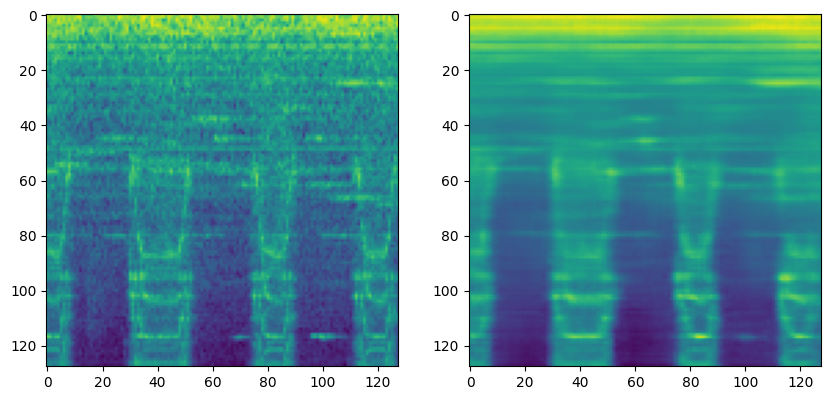

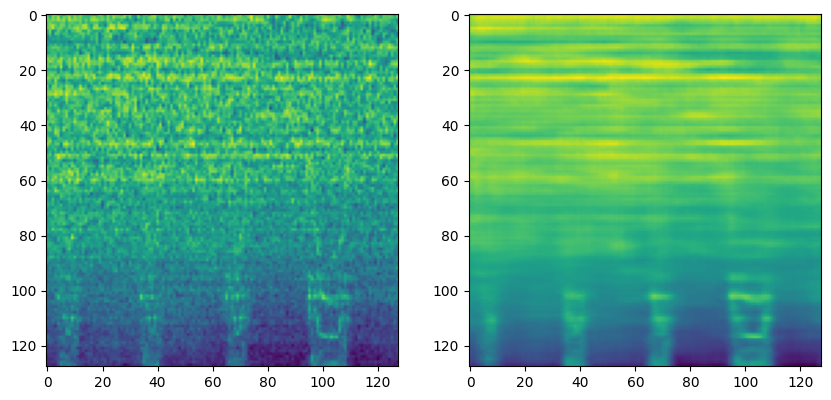

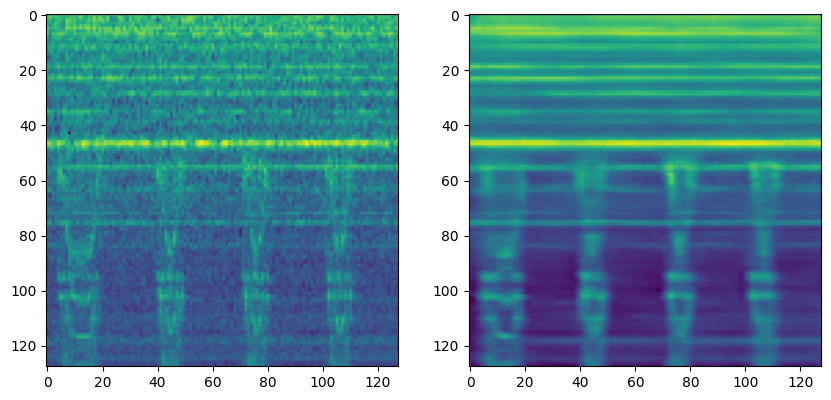

In [24]:
def show_some_predictions(dl, model, start_index, n_samples, image=False):
    shape = (-1, params.feature.n_mels, params.feature.n_mels) if image else (-1, 640)
    
    x, y = next(iter(dl))
    
    with torch.no_grad():
        yhat = model(x)
    
    x = x.cpu().numpy().reshape(shape)
    yhat = yhat.cpu().numpy().reshape(shape)
    print(x.shape, yhat.shape)
    
    for sample_idx in range(start_index, start_index + n_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        if image:
            axs[0].imshow(x[sample_idx])
            axs[1].imshow(yhat[sample_idx])
        else:
            axs[0].plot(x[sample_idx])
            axs[1].plot(yhat[sample_idx])

show_some_predictions(task2.train_dataloader(), task2.model.to(device), 0, 3, image=True)

# Testing on Development dataset

## Testing for CNNAE

In [25]:
class DatasetCNNTest(DatasetCNN):
    def get_test_batch_x(self, file_index, n_mels=params.feature.n_mels, steps=20):
        log_mel_spectrogram = self.X[file_index]
        vector_array_size = (log_mel_spectrogram.shape[1] - n_mels + 1) // steps
        vector_array = np.zeros((vector_array_size, n_mels, n_mels))
        for t in range(vector_array_size):
            vector_array[t] = log_mel_spectrogram[:, t*steps:t*steps+n_mels]
        return vector_array

In [26]:
def file_to_vector_array_2d(file_name,
                         n_mels=128,
                         steps=20,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a 2d vector array.
    file_name : str
        target .wav file
    return : np.array( np.array( float ) )
        vector array
        * dataset.shape = (dataset_size, feature_vector_length)
    """
    # 02 generate melspectrogram using librosa
    y, sr = com.file_load(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vector_array_size = (log_mel_spectrogram.shape[1] - n_mels + 1) // steps

    # 06 generate feature vectors by concatenating multiframes
    vector_array = np.zeros((vector_array_size, n_mels, n_mels))
    for t in range(vector_array_size):
        vector_array[t] = log_mel_spectrogram[:, t*steps:t*steps+n_mels]

    return vector_array

In [27]:
def test_cnn():
    # make output result directory
    os.makedirs(params.result_directory, exist_ok=True)

    # load base directory
    dirs = com.select_dirs(param=params, mode=params.mode)
    print(dirs)
    
    # initialize lines in csv for AUC and pAUC
    csv_lines = []

    # PyTorch version specific...
    to_tensor = pytorch_common.ToTensor1ch(image=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # loop of the base directory
    for idx, target_dir in enumerate(dirs):
        # idx = 0
        # target_dir = '/kaggle/input/eurecom-aml-2022-challenge-2/eval_data/eval_data/slider'
        print("\n===========================")
        # it indicates how many machine type we have [1/1]
        print("[{idx}/{total}] {dirname}".format(dirname=target_dir, idx=idx+1, total=len(dirs)))
        machine_type = os.path.split(target_dir)[1] # slider

        print("============== MODEL LOAD ==============")
        # set model path
        model_file = "{model}/model_{machine_type}.pth".format(model=params.model_directory,
                                                               machine_type=machine_type)

        # load model file
        if not os.path.exists(model_file):
            com.logger.error("{} model not found ".format(machine_type))
            sys.exit(-1)
            
        com.logger.info("loading model: {}".format(model_file))
        
        model = CNNAE(skip_connections = params.skip_connection).to(device)
        
        pytorch_common.load_weights(model, model_file)
        
        model.eval()
        if params.mode: # if True, development !
            # results by type
            csv_lines.append([machine_type])
            csv_lines.append(["id", "AUC", "pAUC"])
            performance = []
        
        # contain the available id
        # train ['id_00', 'id_02', 'id_04']
        # test ['id_01', 'id_03', 'id_05']
        machine_id_list = get_machine_id_list_for_test(target_dir)
        print(machine_id_list)
        for id_str in machine_id_list:
            # load test file
            test_files, y_true = test_file_list_generator(target_dir, id_str, mode=params.mode)
            
            # setup anomaly score file path
            anomaly_score_csv = "{result}/anomaly_score_{machine_type}_{id_str}.csv".format(
                                                                                     result=params.result_directory,
                                                                                     machine_type=machine_type,
                                                                                     id_str=id_str)
            anomaly_score_list = []

            print("\n============== BEGIN TEST FOR A MACHINE ID ==============")
            y_pred = [0. for k in test_files]
            for file_idx, file_path in tqdm(enumerate(test_files), total=len(test_files)):
                try:
                    data_ = file_to_vector_array_2d(file_path,
                                                    n_mels=params.feature.n_mels,
                                                    n_fft=params.feature.n_fft,
                                                    hop_length=params.feature.hop_length,
                                                    power=params.feature.power)
                    data_ = pytorch_common.normalize_0to1(data_)
                    
                    with torch.no_grad():
                        yhat = model(to_tensor(data_)).cpu().detach().numpy().reshape(data_.shape)
                        errors = np.mean(np.square(data_ - yhat), axis=1)

                    y_pred[file_idx] = np.mean(errors)
                    
                    anomaly_score_list.append([os.path.basename(file_path), y_pred[file_idx]])
                except:
                    com.logger.error("file broken!!: {}".format(file_path))
                    sys.exit(-1)

            # save anomaly score
            save_csv(save_file_path=anomaly_score_csv, save_data=anomaly_score_list)
            com.logger.info("anomaly score result ->  {}".format(anomaly_score_csv))

            if params.mode:
                # append AUC and pAUC to lists
                print(y_true[:10])
                print(y_pred[:10])
                auc = metrics.roc_auc_score(y_true, y_pred)
                p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=params.max_fpr)
                csv_lines.append([id_str.split("_", 1)[1], auc, p_auc])
                performance.append([auc, p_auc])
                com.logger.info("AUC : {}".format(auc))
                com.logger.info("pAUC : {}".format(p_auc))

            print("\n============ END OF TEST FOR A MACHINE ID ============")

        if params.mode:
            # calculate averages for AUCs and pAUCs
            averaged_performance = numpy.mean(numpy.array(performance, dtype=float), axis=0)
            csv_lines.append(["Average"] + list(averaged_performance))
            csv_lines.append([])

    if params.mode:
        # output results
        result_path = "{result}/{file_name}".format(result=params.result_directory, file_name=params.result_file)
        com.logger.info("AUC and pAUC results -> {}".format(result_path))
        save_csv(save_file_path=result_path, save_data=csv_lines)

test_cnn()

2024-01-07 19:38:52,764 - INFO - load_directory <- development
2024-01-07 19:38:52,771 - INFO - loading model: ./model/model_slider.pth
2024-01-07 19:38:52,798 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider_id_00
2024-01-07 19:38:52,805 - INFO - test_file  num : 456


['/kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider']

[1/1] /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider
============== MODEL LOAD ==============
['id_00', 'id_02', 'id_04']


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 456/456 [00:23<00:00, 19.79it/s]
2024-01-07 19:39:15,856 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_00.csv
2024-01-07 19:39:15,872 - INFO - AUC : 0.9923595505617977
2024-01-07 19:39:15,873 - INFO - pAUC : 0.9605263157894737
2024-01-07 19:39:15,875 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider_id_02
2024-01-07 19:39:15,889 - INFO - test_file  num : 367


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0007062113249377111, 0.0007369323210013016, 0.0007958573261797623, 0.0006773583453213131, 0.00071892801218348, 0.0007878549228764573, 0.0006346715522396408, 0.0006297955503747762, 0.0007590716810741294, 0.0007440502423580773]

============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 367/367 [00:17<00:00, 20.86it/s]
2024-01-07 19:39:33,495 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_02.csv
2024-01-07 19:39:33,504 - INFO - AUC : 0.7719850187265918
2024-01-07 19:39:33,505 - INFO - pAUC : 0.6031933767001774
2024-01-07 19:39:33,506 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/dev_data/dev_data/slider_id_04
2024-01-07 19:39:33,519 - INFO - test_file  num : 278


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0007459265339242543, 0.0007093169531285176, 0.0007512833221818927, 0.0010123209931249605, 0.0007634998152421165, 0.0006864493302852149, 0.0007571761900601145, 0.0006671848913392189, 0.0006856162160830293, 0.0009106776624533418]

============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:11<00:00, 24.63it/s]
2024-01-07 19:39:44,819 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_04.csv
2024-01-07 19:39:44,831 - INFO - AUC : 0.9480337078651685
2024-01-07 19:39:44,832 - INFO - pAUC : 0.783264340626848
2024-01-07 19:39:44,833 - INFO - AUC and pAUC results -> ./result/result.csv


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0007350933951371569, 0.0008529355381147582, 0.0007295111051430886, 0.0008087356469483223, 0.0007518938981318494, 0.0007546912051289731, 0.000764855988164267, 0.0008269716427480223, 0.0009059665193371666, 0.0007955176338524327]

============ END OF TEST FOR A MACHINE ID ============


In [28]:
def upto_6digits(cell):
    if not cell[0].isdigit(): return cell
    return f'{float(cell):.6f}'



In [29]:
if params.mode:
    with open('./result/result.csv') as f:
        for l in f.readlines():
            l = l.strip() #replace('\n', '')
            if ',' not in l:
                print(l)
                continue
            ls = l.split(',')
            print(f'{ls[0]}\t\t{upto_6digits(ls[1])}\t\t{upto_6digits(ls[2])}')

slider
id		AUC		pAUC
00		0.992360		0.960526
02		0.771985		0.603193
04		0.948034		0.783264
Average		0.904126		0.782328



## Thresholding

In [30]:
#id 00, 02, 04
df0 = pd.read_csv('./result/anomaly_score_slider_id_00.csv', delimiter=',', header=None)
df2 = pd.read_csv('./result/anomaly_score_slider_id_02.csv', delimiter=',', header=None)
df4 = pd.read_csv('./result/anomaly_score_slider_id_04.csv', delimiter=',', header=None)

dfs = [df0, df2, df4]
anomalyscores = pd.concat(dfs)
anomalyscores = anomalyscores.rename(columns={0: "file_name", 1: "anomaly_score"})
anomalyscores

file_name  anomaly_score
0     normal_id_00_00000000.wav       0.000706
1     normal_id_00_00000001.wav       0.000737
2     normal_id_00_00000002.wav       0.000796
3     normal_id_00_00000003.wav       0.000677
4     normal_id_00_00000004.wav       0.000719
..                          ...            ...
273  anomaly_id_04_00000173.wav       0.000859
274  anomaly_id_04_00000174.wav       0.001131
275  anomaly_id_04_00000175.wav       0.000942
276  anomaly_id_04_00000176.wav       0.000903
277  anomaly_id_04_00000177.wav       0.000963

[1101 rows x 2 columns]

<Axes: >

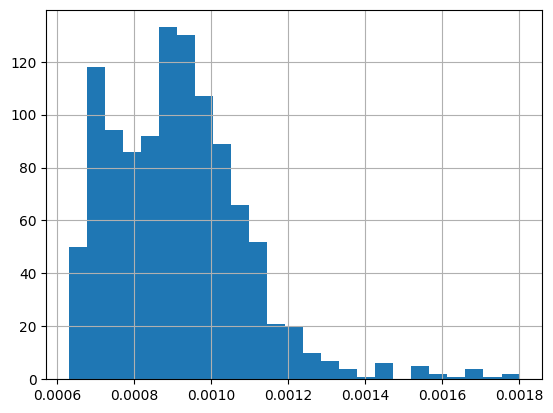

In [31]:
anomalyscores['anomaly_score'].hist(bins=25)

In [32]:
anomalyscores = anomalyscores.sort_values(by=['anomaly_score'], ascending=True)
anomalyscores

file_name  anomaly_score
7     normal_id_00_00000007.wav       0.000630
6     normal_id_00_00000006.wav       0.000635
56    normal_id_00_00000056.wav       0.000641
26    normal_id_00_00000026.wav       0.000641
77    normal_id_00_00000077.wav       0.000642
..                          ...            ...
307  anomaly_id_00_00000207.wav       0.001682
290  anomaly_id_00_00000190.wav       0.001701
171  anomaly_id_00_00000071.wav       0.001741
103  anomaly_id_00_00000003.wav       0.001755
328  anomaly_id_00_00000228.wav       0.001800

[1101 rows x 2 columns]

### Setting a threshold

In [33]:
# Preprocessing
def map_filename(filename):
    if filename.startswith('normal'):
        return 0
    elif filename.startswith('anomaly'):
        return 1

anomalyscores['file_name'] = anomalyscores['file_name'].apply(map_filename)
anomalyscores

file_name  anomaly_score
7            0       0.000630
6            0       0.000635
56           0       0.000641
26           0       0.000641
77           0       0.000642
..         ...            ...
307          1       0.001682
290          1       0.001701
171          1       0.001741
103          1       0.001755
328          1       0.001800

[1101 rows x 2 columns]

In [34]:
anomalyscores['num'] = range(len(anomalyscores))

In [35]:
anomalyscores

file_name  anomaly_score   num
7            0       0.000630     0
6            0       0.000635     1
56           0       0.000641     2
26           0       0.000641     3
77           0       0.000642     4
..         ...            ...   ...
307          1       0.001682  1096
290          1       0.001701  1097
171          1       0.001741  1098
103          1       0.001755  1099
328          1       0.001800  1100

[1101 rows x 3 columns]

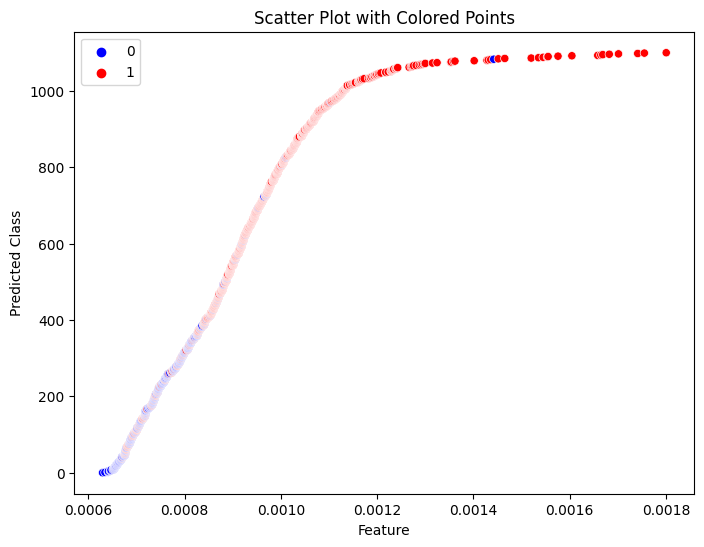

In [36]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x='anomaly_score', y='num', hue='file_name', data=anomalyscores, palette={0: 'blue', 1: 'red'})
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Feature')
plt.ylabel('Predicted Class')
plt.legend(loc='best')
plt.show()

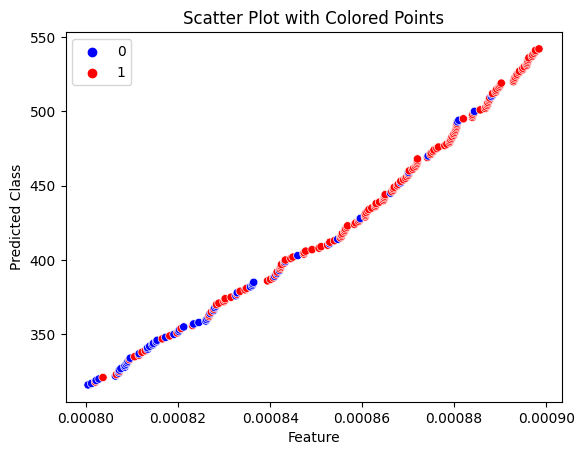

In [37]:
#plt.figure(figsize=(8, 6))

smaller_df = anomalyscores[anomalyscores['anomaly_score'] > 0.0008]
smaller_df = smaller_df[smaller_df['anomaly_score'] < 0.0009]
sns.scatterplot(x='anomaly_score', y='num', hue='file_name', data=smaller_df, palette={0: 'blue', 1: 'red'})
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Feature')
plt.ylabel('Predicted Class')
plt.legend(loc='best')
plt.show()

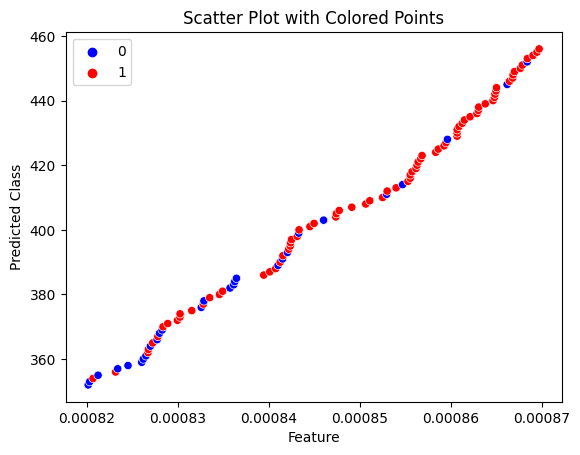

In [38]:
smaller_df = anomalyscores[anomalyscores['anomaly_score'] > 0.00082]
smaller_df = smaller_df[smaller_df['anomaly_score'] < 0.00087]
sns.scatterplot(x='anomaly_score', y='num', hue='file_name', data=smaller_df, palette={0: 'blue', 1: 'red'})
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Feature')
plt.ylabel('Predicted Class')
plt.legend(loc='best')
plt.show()

### Setting the threshold as the median of this chunk of the dataset.

In [39]:
threshold = round(smaller_df['anomaly_score'].median(), 6)
print(f'Any sound with an anomaly score higher than {threshold} will be classified as an anomalous sound.')

Any sound with an anomaly score higher than 0.000847 will be classified as an anomalous sound.


# Testing on the Evaluation dataset and generating submission file

In [40]:
# re-training on evaluation dataset
params.mode = False
# train() # due to the memory restriction, restart the kernel and train on only evaluation dataset

In [41]:
task2 = train_cnnae()

==== Start training [slider] with 1 GPU(s). ====
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 131, 131]               0
            Conv2d-2           [-1, 32, 64, 64]             832
              ReLU-3           [-1, 32, 64, 64]               0
         ZeroPad2d-4           [-1, 32, 67, 67]               0
            Conv2d-5           [-1, 64, 32, 32]          51,264
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 15, 15]          73,856
              ReLU-9          [-1, 128, 15, 15]               0
          Dropout-10          [-1, 128, 15, 15]               0
           Conv2d-11            [-1, 256, 7, 7]         295,168
             ReLU-12            [-1, 256, 7, 7]               0
          Dropout-13            [-1, 256, 7, 7]       

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


Sanity Checking: 0it [00:00, ?it/s]

2024-01-07 19:41:12,412 - INFO - Creating Val
2024-01-07 19:41:12,444 - INFO - Created the  dataset shape ((237, 128, 313))
2024-01-07 19:41:21,217 - INFO - End Val
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
2024-01-07 19:41:21,356 - INFO - Creating Train
2024-01-07 19:41:21,367 - INFO - Created the  dataset shape ((2133, 128, 313))
2024-01-07 19:42:36,434 - INFO - End Train
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

saved ./model/model_slider.pth.



2024-01-07 19:53:04,683 - INFO - Creating Train
2024-01-07 19:53:04,700 - INFO - Created the  dataset shape ((2133, 128, 313))
2024-01-07 19:54:17,397 - INFO - End Train


(64, 128, 128) (64, 128, 128)


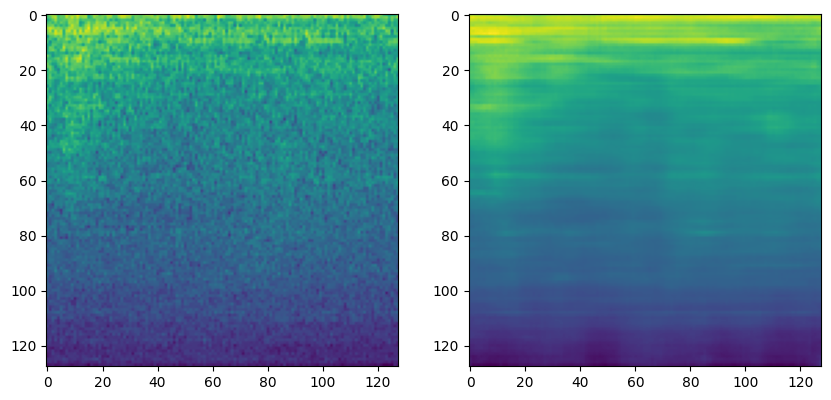

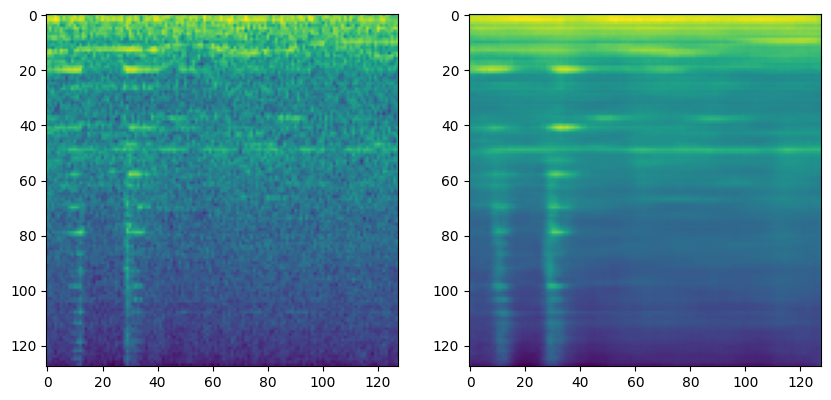

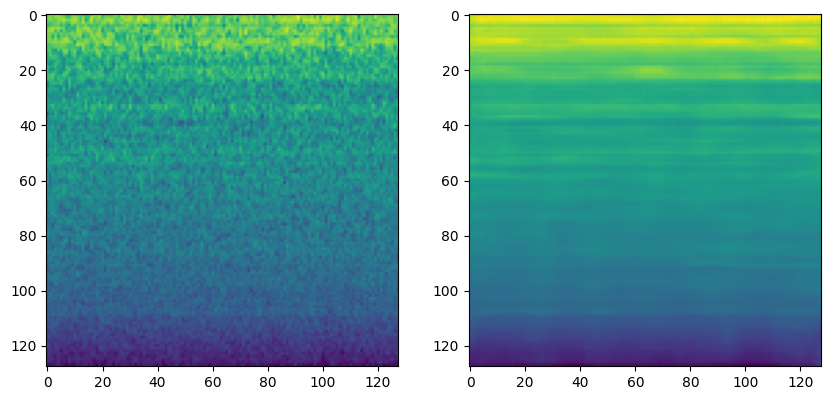

In [42]:
#load_weights(task2.model, 'model/model_slider.pth')
def show_some_predictions(dl, model, start_index, n_samples, image=False):
    shape = (-1, params.feature.n_mels, params.feature.n_mels) if image else (-1, 640)
    
    x, y = next(iter(dl))
    
    with torch.no_grad():
        yhat = model(x)
    
    x = x.cpu().numpy().reshape(shape)
    yhat = yhat.cpu().numpy().reshape(shape)
    print(x.shape, yhat.shape)
    
    for sample_idx in range(start_index, start_index + n_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        if image:
            axs[0].imshow(x[sample_idx])
            axs[1].imshow(yhat[sample_idx])
        else:
            axs[0].plot(x[sample_idx])
            axs[1].plot(yhat[sample_idx])
            
show_some_predictions(task2.train_dataloader(), task2.model.to(device), 0, 3, image=True)

In [43]:
test_cnn()

2024-01-07 19:54:39,409 - INFO - load_directory <- evaluation
2024-01-07 19:54:39,412 - INFO - loading model: ./model/model_slider.pth
2024-01-07 19:54:39,438 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_01
2024-01-07 19:54:39,441 - INFO - test_file  num : 278


['/kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider']

[1/1] /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider
============== MODEL LOAD ==============
['id_01', 'id_03', 'id_05']


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:13<00:00, 20.72it/s]
2024-01-07 19:54:52,865 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_01.csv
2024-01-07 19:54:52,870 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_03
2024-01-07 19:54:52,880 - INFO - test_file  num : 278



============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:13<00:00, 20.22it/s]
2024-01-07 19:55:06,642 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_03.csv
2024-01-07 19:55:06,645 - INFO - target_dir : /kaggle/input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider_id_05
2024-01-07 19:55:06,649 - INFO - test_file  num : 278



============ END OF TEST FOR A MACHINE ID ============


============== BEGIN TEST FOR A MACHINE ID ==============


100%|██████████| 278/278 [00:11<00:00, 25.18it/s]
2024-01-07 19:55:17,703 - INFO - anomaly score result ->  ./result/anomaly_score_slider_id_05.csv



============ END OF TEST FOR A MACHINE ID ============


In [44]:
import numpy as np
import pandas as pd

df1 = pd.read_csv('./result/anomaly_score_slider_id_01.csv', delimiter=',', header=None)
df3 = pd.read_csv('./result/anomaly_score_slider_id_03.csv', delimiter=',', header=None)
df5 = pd.read_csv('./result/anomaly_score_slider_id_05.csv', delimiter=',', header=None)

dfs = [df1, df3, df5]
eval_df = pd.concat(dfs)
eval_df = eval_df.rename(columns={0: "file_name", 1: "anomaly_score"})

eval_df.to_csv('submission.csv',index = False)


In [45]:
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [46]:
create_download_link(filename='submission.csv')

In [47]:
eval_df.head()

file_name  anomaly_score
0  id_01_00000000.wav       0.000932
1  id_01_00000001.wav       0.000705
2  id_01_00000002.wav       0.000702
3  id_01_00000003.wav       0.000727
4  id_01_00000004.wav       0.000879

# Thresholding

<Axes: >

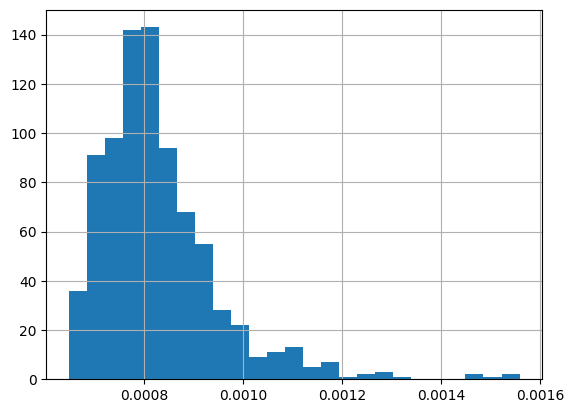

In [48]:
eval_df['anomaly_score'].hist(bins=25)

In [57]:
df_outliers = eval_df[eval_df['anomaly_score'] > threshold]
df_outliers

file_name  anomaly_score
0    id_01_00000000.wav       0.000932
4    id_01_00000004.wav       0.000879
17   id_01_00000017.wav       0.000885
21   id_01_00000021.wav       0.000864
24   id_01_00000024.wav       0.000863
..                  ...            ...
268  id_05_00000268.wav       0.000877
269  id_05_00000269.wav       0.000885
270  id_05_00000270.wav       0.000849
271  id_05_00000271.wav       0.000864
277  id_05_00000277.wav       0.000862

[281 rows x 2 columns]

In [58]:
eval_df

file_name  anomaly_score
0    id_01_00000000.wav       0.000932
1    id_01_00000001.wav       0.000705
2    id_01_00000002.wav       0.000702
3    id_01_00000003.wav       0.000727
4    id_01_00000004.wav       0.000879
..                  ...            ...
273  id_05_00000273.wav       0.000788
274  id_05_00000274.wav       0.000792
275  id_05_00000275.wav       0.000794
276  id_05_00000276.wav       0.000757
277  id_05_00000277.wav       0.000862

[834 rows x 2 columns]

In [59]:
df_eval.file.iloc[0]

PosixPath('../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/id_01_00000000.wav')

[]

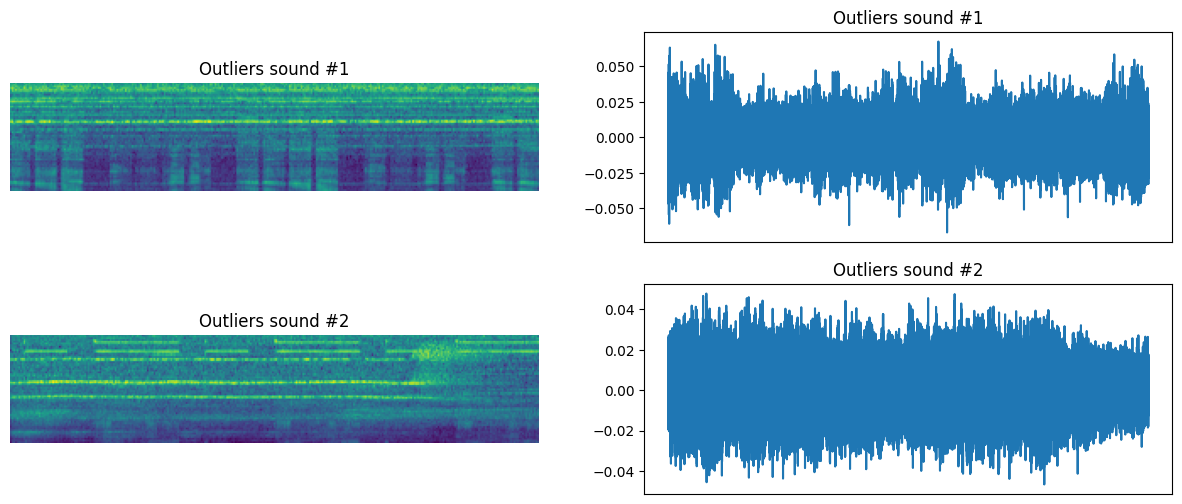

In [61]:
#load a sound from outliers
sound_file1 = '../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/' + df_outliers.file_name.iloc[0]
sound1, samplerate = sf.read(sound_file1)

#load another sound from outliers
sound_file2 = '../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/' + df_outliers.file_name.iloc[1]
sound2, samplerate = sf.read(sound_file2)

fig, ax = plt.subplots(2, 2, figsize = (15, 3*2))
mels_n, wav_n = get_log_mel_spectrogram(sound_file1)
ax[0, 0].set_title("Outliers sound #1")
ax[0, 0].imshow(mels_n)
ax[0, 0].axis('off')
ax[0, 1].set_title("Outliers sound #1")
ax[0, 1].plot(wav_n)
ax[0, 1].get_xaxis().set_ticks([])

mels_a, wav_a = get_log_mel_spectrogram(sound_file2)
ax[1, 0].set_title("Outliers sound #2")
ax[1, 0].imshow(mels_a)
ax[1, 0].axis('off')
ax[1, 1].set_title("Outliers sound #2")
ax[1, 1].plot(wav_a)
ax[1, 1].get_xaxis().set_ticks([])

### Checking the threshold

In [62]:
df_outliers = df_outliers.sort_values(by=['anomaly_score'], ascending=False)
df_outliers

file_name  anomaly_score
239  id_01_00000239.wav       0.001558
170  id_01_00000170.wav       0.001524
175  id_01_00000175.wav       0.001513
215  id_05_00000215.wav       0.001464
276  id_01_00000276.wav       0.001461
..                  ...            ...
270  id_05_00000270.wav       0.000849
137  id_05_00000137.wav       0.000848
255  id_01_00000255.wav       0.000848
156  id_01_00000156.wav       0.000847
116  id_01_00000116.wav       0.000847

[281 rows x 2 columns]

[]

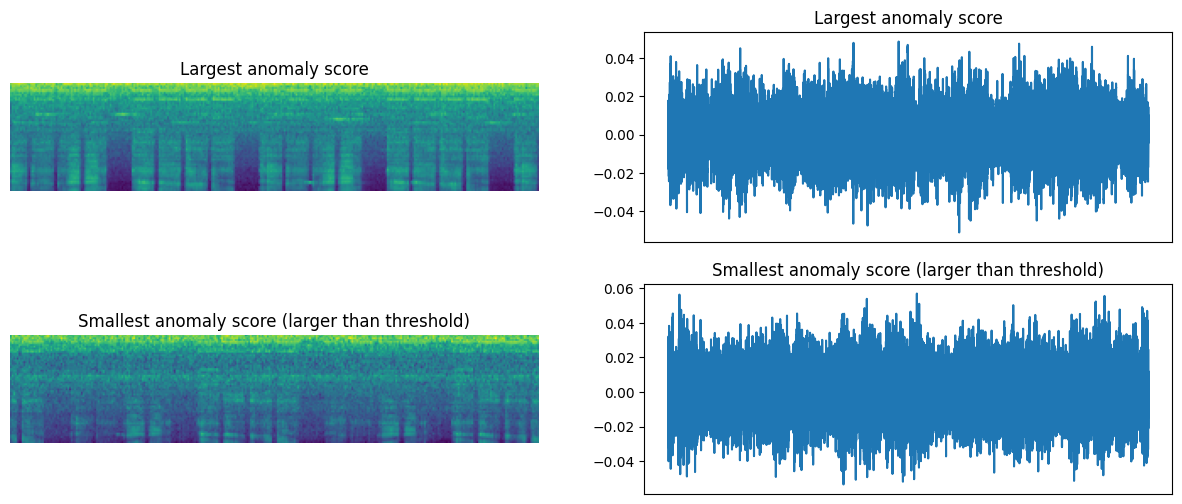

In [64]:
#load the first sound from outliers (desdending order) - the highest anomaly score
sound_file1 = '../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/' + df_outliers.file_name.iloc[0]
sound1, samplerate = sf.read(sound_file1)

#load the last sound from outliers - the lowest anomaly score
sound_file2 = '../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/' + df_outliers.file_name.iloc[-1]
sound2, samplerate = sf.read(sound_file2)

fig, ax = plt.subplots(2, 2, figsize = (15, 3*2))
mels_n, wav_n = get_log_mel_spectrogram(sound_file1)
ax[0, 0].set_title("Largest anomaly score")
ax[0, 0].imshow(mels_n)
ax[0, 0].axis('off')
ax[0, 1].set_title("Largest anomaly score")
ax[0, 1].plot(wav_n)
ax[0, 1].get_xaxis().set_ticks([])

mels_a, wav_a = get_log_mel_spectrogram(sound_file2)
ax[1, 0].set_title("Smallest anomaly score (larger than threshold)")
ax[1, 0].imshow(mels_a)
ax[1, 0].axis('off')
ax[1, 1].set_title("Smallest anomaly score (larger than threshold)")
ax[1, 1].plot(wav_a)
ax[1, 1].get_xaxis().set_ticks([])

In [65]:
df_normals = eval_df[eval_df['anomaly_score'] <= 0.001].sort_values(by=['anomaly_score'], ascending=False)
df_normals

file_name  anomaly_score
254  id_05_00000254.wav       0.000997
121  id_05_00000121.wav       0.000995
199  id_01_00000199.wav       0.000994
231  id_05_00000231.wav       0.000994
85   id_03_00000085.wav       0.000990
..                  ...            ...
39   id_01_00000039.wav       0.000662
272  id_01_00000272.wav       0.000661
174  id_01_00000174.wav       0.000654
29   id_01_00000029.wav       0.000653
220  id_01_00000220.wav       0.000648

[770 rows x 2 columns]

In [66]:
eval_df['predicted_class'] = (eval_df['anomaly_score'] > threshold).astype(int)
eval_df

file_name  anomaly_score  predicted_class
0    id_01_00000000.wav       0.000932                1
1    id_01_00000001.wav       0.000705                0
2    id_01_00000002.wav       0.000702                0
3    id_01_00000003.wav       0.000727                0
4    id_01_00000004.wav       0.000879                1
..                  ...            ...              ...
273  id_05_00000273.wav       0.000788                0
274  id_05_00000274.wav       0.000792                0
275  id_05_00000275.wav       0.000794                0
276  id_05_00000276.wav       0.000757                0
277  id_05_00000277.wav       0.000862                1

[834 rows x 3 columns]

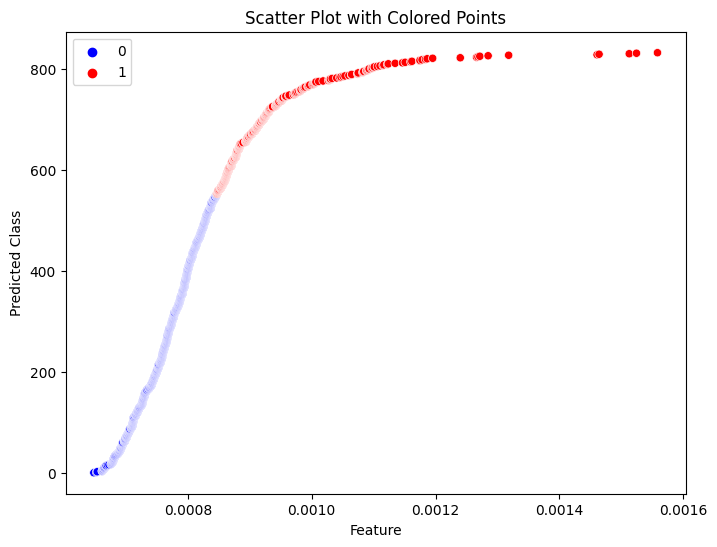

In [70]:
temp_df = eval_df[['anomaly_score', 'predicted_class']].sort_values(by="anomaly_score")
temp_df['num'] = range(len(temp_df))

plt.figure(figsize=(8, 6))
sns.scatterplot(x='anomaly_score', y='num', hue='predicted_class', data=temp_df, palette={0: 'blue', 1: 'red'})
plt.title('Scatter Plot with Colored Points')
plt.xlabel('Feature')
plt.ylabel('Predicted Class')
plt.legend(loc='best')
plt.show()

## Checking some classifications

### Normal predictions

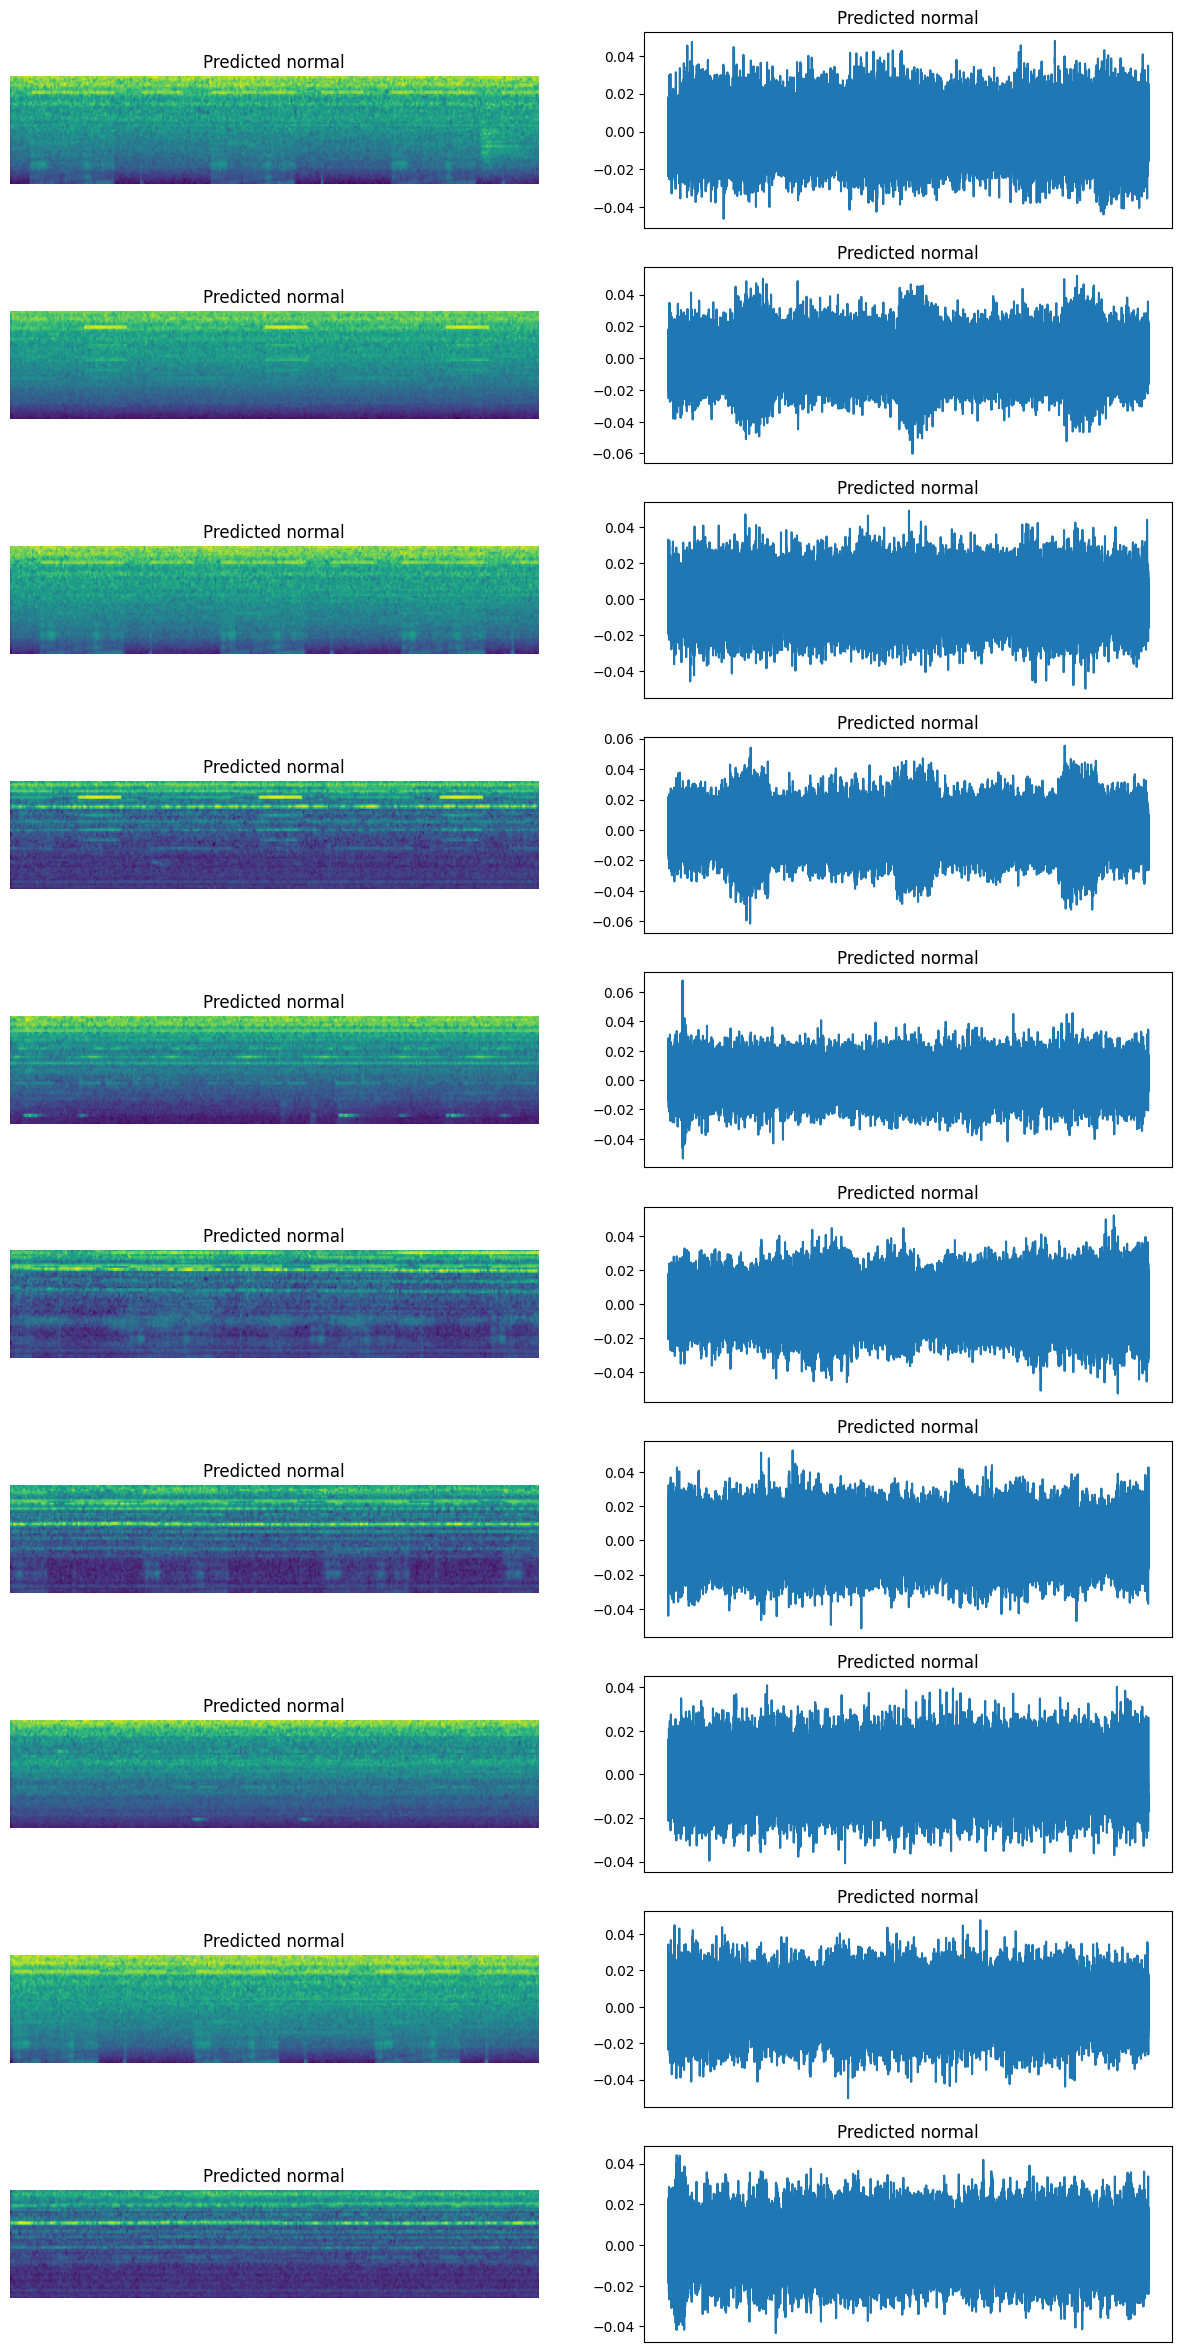

In [72]:
predicted_normal = eval_df[eval_df['predicted_class'] == 0]
fig, ax = plt.subplots(10, 2, figsize = (15, 3*10))

for i in range(10):
    sound_file1 = '../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/' + predicted_normal.file_name.iloc[i]
    sound1, samplerate = sf.read(sound_file1)
    
    mels_n, wav_n = get_log_mel_spectrogram(sound_file1)
    ax[i, 0].set_title("Predicted normal")
    ax[i, 0].imshow(mels_n)
    ax[i, 0].axis('off')
    ax[i, 1].set_title("Predicted normal")
    ax[i, 1].plot(wav_n)
    ax[i, 1].get_xaxis().set_ticks([])

### Anomaly predictions

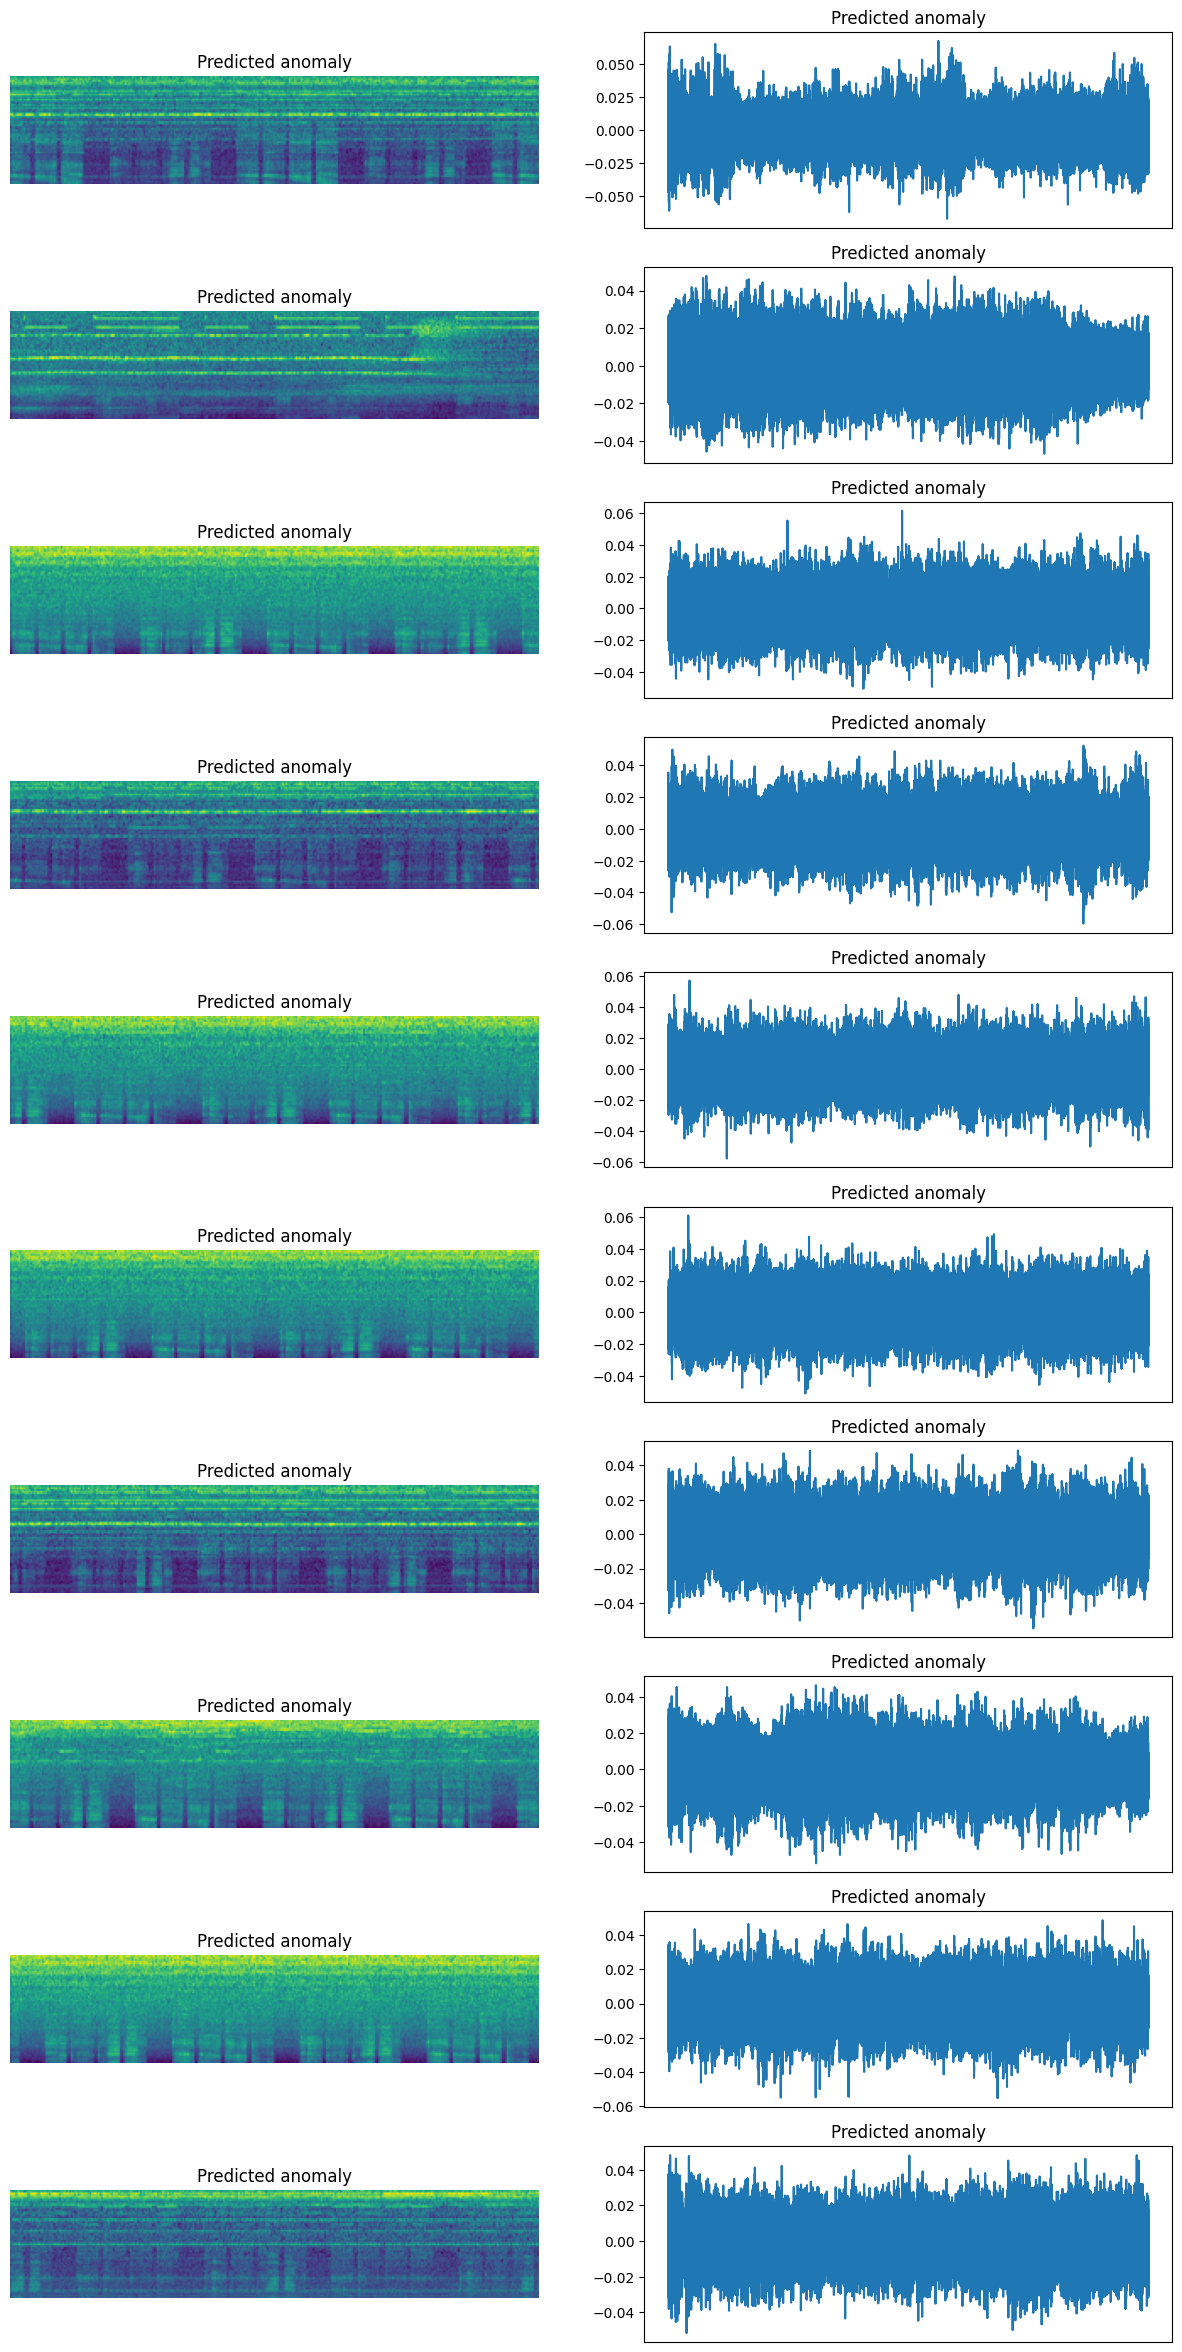

In [74]:
predicted_anomaly = eval_df[eval_df['predicted_class'] == 1]
fig, ax = plt.subplots(10, 2, figsize = (15, 3*10))

for i in range(10):
    sound_file1 = '../input/eurecom-aml-2023-challenge-2/eval_data/eval_data/slider/test/' + predicted_anomaly.file_name.iloc[i]
    sound1, samplerate = sf.read(sound_file1)
    
    mels_n, wav_n = get_log_mel_spectrogram(sound_file1)
    ax[i, 0].set_title("Predicted anomaly")
    ax[i, 0].imshow(mels_n)
    ax[i, 0].axis('off')
    ax[i, 1].set_title("Predicted anomaly")
    ax[i, 1].plot(wav_n)
    ax[i, 1].get_xaxis().set_ticks([])